# III Machine Learning: Credit Approval Data
In this notebook, we will explore using different machine learning classifiers to predict credit risk, using the given data file.

We will first conduct some basic preprocessing of the given data. This will consist of a train test split, followed by one hot encoding and standard scaling.

For each classifier, we will perform a cross validation grid search to approximate optimal hyperparameter values, before evaluating performance on the test set.

Finally, we will compare the performance of each classifier on the test set and investigate feature importance for the best performing model.

***
## Importing libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

In [2]:
cc_approvals = pd.read_csv('cc_approvals_DB.csv')

We will now briefly look at some aspects of the data. Below is an overview of what data entries look like, some statistics about each feature, as well as a pair plot of each numerical feature.

In [3]:
print('Some of the data:')
display(cc_approvals)
print('\nOverview of numerical features:')
display(cc_approvals.describe())
print('\nOverview of categorical features:')
display(cc_approvals.describe(include = 'object'))

Some of the data:


A1     A2      A3 A4 A5  A6  A7    A8 A9 A10  A11 A12 A13    A14  A15  \
0    b  30.83   0.000  u  g   w   v  1.25  t   t    1   f   g  202.0    0   
1    a  58.67   4.460  u  g   q   h  3.04  t   t    6   f   g   43.0  560   
2    a  24.50   0.500  u  g   q   h  1.50  t   f    0   f   g  280.0  824   
3    b  27.83   1.540  u  g   w   v  3.75  t   t    5   t   g  100.0    3   
4    b  20.17   5.625  u  g   w   v  1.71  t   f    0   f   s  120.0    0   
..  ..    ...     ... .. ..  ..  ..   ... ..  ..  ...  ..  ..    ...  ...   
685  b  21.08  10.085  y  p   e   h  1.25  f   f    0   f   g  260.0    0   
686  a  22.67   0.750  u  g   c   v  2.00  f   t    2   t   g  200.0  394   
687  a  25.25  13.500  y  p  ff  ff  2.00  f   t    1   t   g  200.0    1   
688  b  17.92   0.205  u  g  aa   v  0.04  f   f    0   f   g  280.0  750   
689  b  35.00   3.375  u  g   c   h  8.29  f   f    0   t   g    0.0    0   

    Approval  
0          +  
1          +  
2          +  
3          +  
4          +  
..       ...  
685        -  
686        -  
687        -  
688        -  
689        -  

[690 rows x 16 columns]


Overview of numerical features:


A2          A3          A8        A11          A14  \
count  690.000000  690.000000  690.000000  690.00000   690.000000   
mean    31.568171    4.758725    2.223406    2.40000   184.014771   
std     11.853273    4.978163    3.346513    4.86294   172.159274   
min     13.750000    0.000000    0.000000    0.00000     0.000000   
25%     22.670000    1.000000    0.165000    0.00000    80.000000   
50%     28.625000    2.750000    1.000000    0.00000   160.000000   
75%     37.707500    7.207500    2.625000    3.00000   272.000000   
max     80.250000   28.000000   28.500000   67.00000  2000.000000   

                 A15  
count     690.000000  
mean     1017.385507  
std      5210.102598  
min         0.000000  
25%         0.000000  
50%         5.000000  
75%       395.500000  
max    100000.000000


Overview of categorical features:


A1   A4   A5   A6   A7   A9  A10  A12  A13 Approval
count   690  690  690  690  690  690  690  690  690      690
unique    2    3    3   14    9    2    2    2    3        2
top       b    u    g    c    v    t    f    f    g        -
freq    480  525  525  146  408  361  395  374  625      383

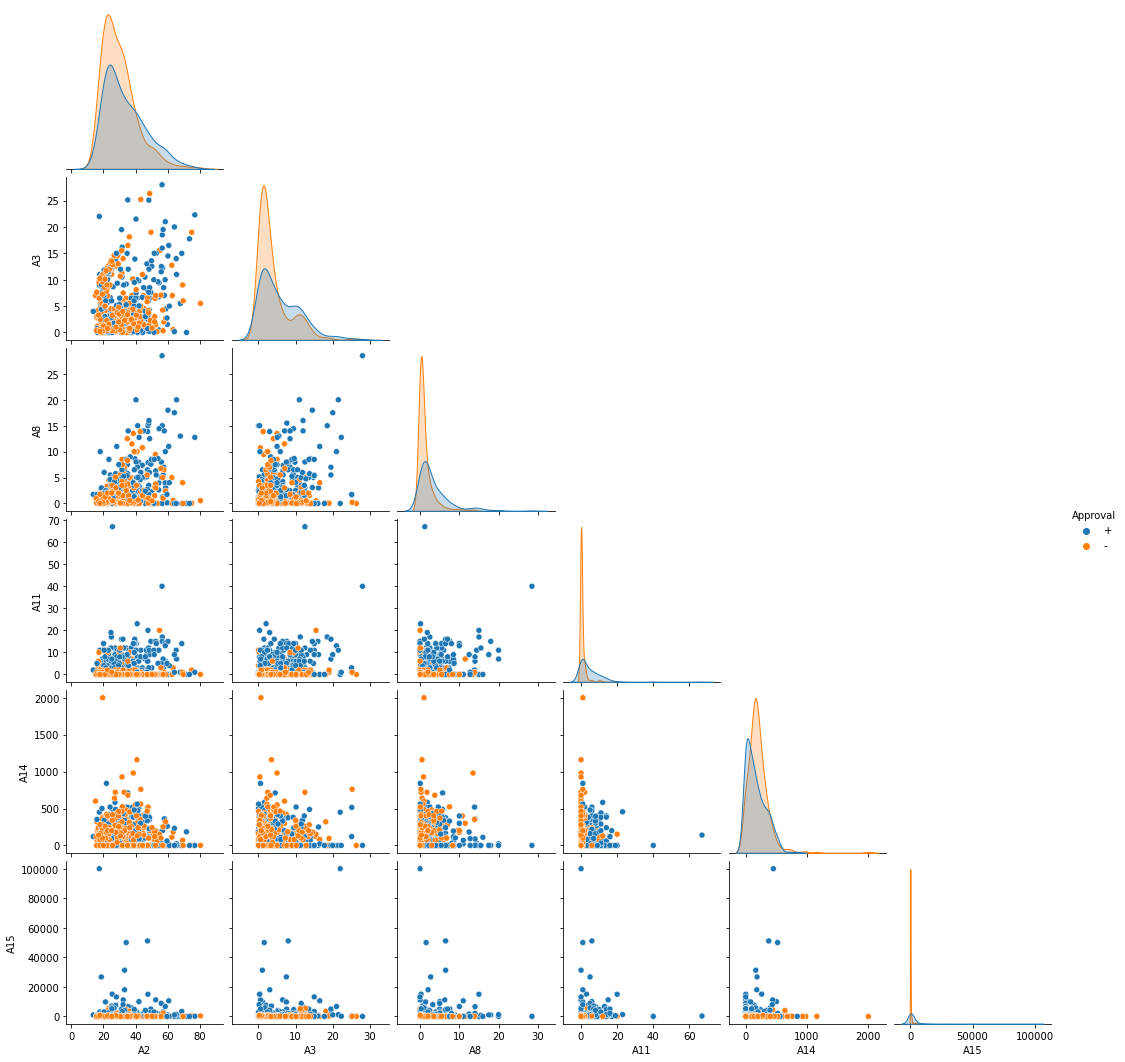

In [4]:
sns.pairplot(cc_approvals, hue = 'Approval', corner = True)
plt.show()

From the above plots, we can see that there are some distinctions between approved and rejected data points which can be seen visually. Hopefully this means we will see strong performances from our classifiers.

***
## Constants and scoring function
Below we set up a seed for reproducibility.

We also set up the scorer by which to perform cross validation and testing, where we use $f_\beta$ with $\beta = 1/4$ because we wish to minimise false negatives (reporting a transaction as legitimate when it is fraudulent).

In [5]:
seed = 42

# Wish to minimise false positives hence maximise precision so use beta < 1
beta = 1 / 4
fbeta = make_scorer(fbeta_score, beta = beta)

# We will want to compare classifier performance for a fixed false positive rate
max_fpr = 0.1

***
## Data preprocessing

Below we will carry out basic preprocessing for our dataset. We first perform a train test split, before separating the categorical and numerical columns for one hot encoding and scaling respectively. Finally we put the categorical and numerical data back together.

In [6]:
# 1 and 0 is machine readable, '+' and '-' is not
cc_approvals['Approval'] = cc_approvals['Approval'].map({'+': 1, '-': 0})

In [7]:
# Train test split
X = cc_approvals.drop('Approval', axis = 1)
y = cc_approvals.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = seed)

In [8]:
def split_cat_and_num(X):
    cats = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
    nums = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
    X_cat = X[cats]
    X_num = X[nums]
    return X_cat, X_num

X_train_cat, X_train_num = split_cat_and_num(X_train)
X_test_cat, X_test_num = split_cat_and_num(X_test)

In [9]:
# Scaling and one hot encoding
# Used standard scaler since we have limited insights about the features
standard_scaler = StandardScaler()
encoder = OneHotEncoder(sparse = False, drop = 'first', handle_unknown = 'ignore')

X_train_cat_onehot = encoder.fit_transform(X_train_cat)
X_train_num_scaled = standard_scaler.fit_transform(X_train_num)

X_test_cat_onehot = encoder.transform(X_test_cat)
X_test_num_scaled = standard_scaler.transform(X_test_num)

In [10]:
X_train_final = np.hstack([X_train_num_scaled, X_train_cat_onehot])
X_test_final = np.hstack([X_test_num_scaled, X_test_cat_onehot])

***
## Random Forest classifier
The first classifier we will investigate is the random forest classifier. We begin by conducting a grid search over the hyperparameters `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`:

In [11]:
# set the classifier to the random forest
clf = RandomForestClassifier(random_state=seed, n_jobs = -1)

# set the hyperparameter grid
param_grid = [{'n_estimators': [50, 100, 200], 'max_depth': [2, 3, 5],
               'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5]}]

# Set up the GridSearchCV grid search 
# This does not perform the search, it only sets it up. 
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1,
                           cv = 4, scoring =fbeta)

# This is where the search actually occurs. This can be time consuming. 
grid_search.fit(X_train_final, y_train)

# Print the best parameters and best score
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best hyperparameters found:  {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.90


We now compute performance metrics for the best performing parameters:

In [12]:
# Use the best estimator to predict on the test set
best_random_forest_clf = grid_search.best_estimator_
y_pred = best_random_forest_clf.predict(X_test_final)

# Evaluate different scorers
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f_beta_score = fbeta_score(y_test, y_pred, beta = beta)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F_{beta:.3f} Score: {f_beta_score:.2f}")

Accuracy: 0.85
Recall: 0.76
Precision: 0.93
F1 Score: 0.83
F_0.250 Score: 0.92


Finally, we plot the ROC curve, work out the AUC, and output the performance of the model for an FPR below 0.1:

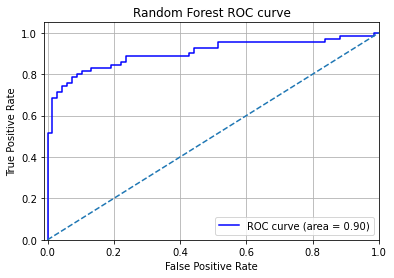

The TPR for a FPR under 0.1 is 0.8000


In [13]:
# Getting predicted probabilities
y_scores = best_random_forest_clf.predict_proba(X_test_final)[:,1]  # Probabilities for the positive class

# Calculating ROC curve
fpr_random_forest_clf, tpr_random_forest_clf, _ = roc_curve(y_test, y_scores)

# Calculating AUC
random_forest_roc_auc = auc(fpr_random_forest_clf, tpr_random_forest_clf)

# Plotting ROC curve
plt.plot(fpr_random_forest_clf, tpr_random_forest_clf,
         label='ROC curve (area = {:.2f})'.format(random_forest_roc_auc), c = 'b')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

random_forest_tpr_under_max = 0

for i in range(len(fpr_random_forest_clf)):
    if fpr_random_forest_clf[i] < 0.1:
        random_forest_tpr_under_max = tpr_random_forest_clf[i]

print(f'The TPR for a FPR under 0.1 is {random_forest_tpr_under_max:.4f}')

***
## Gradient Boosting classifier
We repeat the above but with the Gradient Boosting classifier, performing a grid search over the hyperparameters `n_estimators`, `max_depth`, and `learning_rate`:

In [14]:
# set the classifier to the gradient boosting
clf = GradientBoostingClassifier(random_state=seed)

# set the hyperparameter grid
param_grid = [{'n_estimators': [100, 300, 400, 450], 'max_depth': [2, 3, 5, None],
               'learning_rate': [1e-4, 1e-3, 1e-2]}]

# Set up the GridSearchCV grid search 
# This does not perform the search, it only sets it up. 
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1,
                           cv = 4, scoring = fbeta)

# This is where the search actually occurs. This can be time consuming. 
grid_search.fit(X_train_final, y_train)

# Print the best parameters and best score
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best hyperparameters found:  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score: 0.87


We now compute performance metrics for the best performing parameters:

In [15]:
# Use the best estimator to predict on the test set
best_Gboost_clf = grid_search.best_estimator_
y_pred = best_Gboost_clf.predict(X_test_final)

# Evaluate different scorers
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f_beta_score = fbeta_score(y_test, y_pred, beta = beta)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F_{beta:.3f} Score: {f_beta_score:.2f}")

Accuracy: 0.82
Recall: 0.69
Precision: 0.94
F1 Score: 0.79
F_0.250 Score: 0.92


Finally, we plot the ROC curve, work out the AUC, and output the performance of the model for an FPR below 0.1:

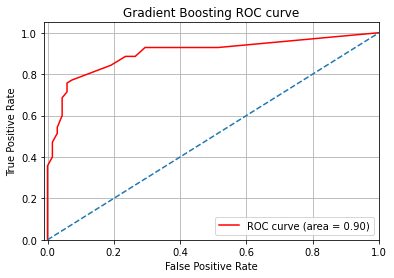

The TPR for a FPR under 0.1 is 0.7714


In [16]:
# Getting predicted probabilities
y_scores = best_Gboost_clf.predict_proba(X_test_final)[:,1]  # Probabilities for the positive class

# Calculating ROC curve
fpr_Gboost_clf, tpr_Gboost_clf, _ = roc_curve(y_test, y_scores)

# Calculating AUC
Gboost_roc_auc = auc(fpr_Gboost_clf, tpr_Gboost_clf)

# Plotting ROC curve
plt.plot(fpr_Gboost_clf, tpr_Gboost_clf,
         label='ROC curve (area = {:.2f})'.format(Gboost_roc_auc), c = 'r')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Gboost_tpr_under_max = 0

for i in range(len(fpr_Gboost_clf)):
    if fpr_Gboost_clf[i] < 0.1:
        Gboost_tpr_under_max = tpr_Gboost_clf[i]

print(f'The TPR for a FPR under 0.1 is {Gboost_tpr_under_max:.4f}')

***
# SVM classifier
We now look at the SVM classifier, performing a grid search over the hyperparameters `C`, `gamma`, and `kernel`:

In [17]:
# set the classifier to the SVC
clf = svm.SVC(random_state=seed, probability = True)

# set the hyperparameter grid
param_grid = [{'C': [1e-3, 1e-2, 1e-1, 1, 10], 'gamma': [1e-2, 1e-1, 1],
               'kernel': ['sigmoid', 'poly', 'rbf'], 'degree': [3, 4, 5]}]

# Set up the GridSearchCV grid search 
# This does not perform the search, it only sets it up. 
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1,
                           cv = 4, scoring = fbeta)

# This is where the search actually occurs. This can be time consuming. 
grid_search.fit(X_train_final, y_train)

# Print the best parameters and best score
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best hyperparameters found:  {'C': 1, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}
Best cross-validation score: 0.87


We now evaluate performance for the best performing hyperparameters:

In [18]:
# Use the best estimator to predict on the test set
best_svm_clf = grid_search.best_estimator_
y_pred = best_svm_clf.predict(X_test_final)

# Evaluate different scorers
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f_beta_score = fbeta_score(y_test, y_pred, beta = beta)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F_{beta:.3f} Score: {f_beta_score:.2f}")

Accuracy: 0.82
Recall: 0.69
Precision: 0.94
F1 Score: 0.79
F_0.250 Score: 0.92


Finally, we plot the ROC curve, work out the AUC, and output the performance of the model for an FPR below 0.1:

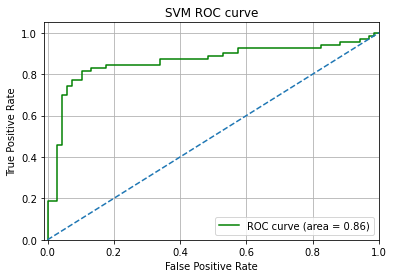

The TPR for a FPR under 0.1 is 0.7714


In [19]:
# Getting predicted probabilities
y_scores = best_svm_clf.predict_proba(X_test_final)[:,1]  # Probabilities for the positive class

# Calculating ROC curve
fpr_svm_clf, tpr_svm_clf, _ = roc_curve(y_test, y_scores)

# Calculating AUC
svm_roc_auc = auc(fpr_svm_clf, tpr_svm_clf)

# Plotting ROC curve
plt.plot(fpr_svm_clf, tpr_svm_clf, label='ROC curve (area = {:.2f})'.format(svm_roc_auc),
         c = 'g')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

svm_tpr_under_max = 0

for i in range(len(fpr_svm_clf)):
    if fpr_svm_clf[i] < 0.1:
        svm_tpr_under_max = tpr_svm_clf[i]

print(f'The TPR for a FPR under 0.1 is {svm_tpr_under_max:.4f}')

***
# Logistic Regression classifier
Our final classifier is the Logistic Regression Classifier. There are some error messages due to solvers not being able to work with different penalties but this can be ignored as the grid search will still work over all possible pairings.

In [20]:
# set the classifier to the logistic regression
clf = LogisticRegression(n_jobs = -1, random_state=seed)

# set the hyperparameter grid
param_grid = [{'C': [1e-2, 1e-1, 1], 'max_iter': [10, 50],
               'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}]

# Set up the GridSearchCV grid search 
# This does not perform the search, it only sets it up. 
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1,
                           cv = 4, scoring = fbeta)

# This is where the search actually occurs. This can be time consuming. 
grid_search.fit(X_train_final, y_train)

# Print the best parameters and best score
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best hyperparameters found:  {'C': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'sag'}
Best cross-validation score: 0.87


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
264 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va

We now evaluate performance for the best performing hyperparameters:

In [21]:
# Use the best estimator to predict on the test set
best_logr_clf = grid_search.best_estimator_
y_pred = best_logr_clf.predict(X_test_final)

# Evaluate different scorers
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f_beta_score = fbeta_score(y_test, y_pred, beta = beta)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F_{beta:.3f} Score: {f_beta_score:.2f}")

Accuracy: 0.84
Recall: 0.80
Precision: 0.88
F1 Score: 0.84
F_0.250 Score: 0.87


Finally, we plot the ROC curve, work out the AUC, and output the performance of the model for an FPR below 0.1:

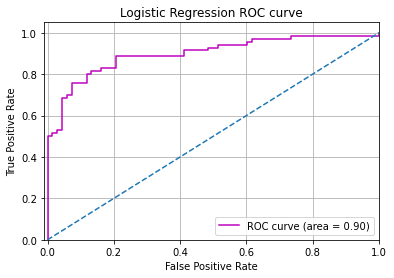

The TPR for a FPR under 0.1 is 0.7571


In [22]:
# Getting predicted probabilities
y_scores = best_logr_clf.predict_proba(X_test_final)[:,1]  # Probabilities for the positive class

# Calculating ROC curve
fpr_logr_clf, tpr_logr_clf, _ = roc_curve(y_test, y_scores)

# Calculating AUC
logr_roc_auc = auc(fpr_logr_clf, tpr_logr_clf)

# Plotting ROC curve
plt.plot(fpr_logr_clf, tpr_logr_clf, label='ROC curve (area = {:.2f})'.format(logr_roc_auc),
         c = 'm')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

logr_tpr_under_max = 0

for i in range(len(fpr_logr_clf)):
    if fpr_logr_clf[i] < 0.1:
        logr_tpr_under_max = tpr_logr_clf[i]

print(f'The TPR for a FPR under 0.1 is {logr_tpr_under_max:.4f}')

***
## Comparing classifiers
By most metrics, including $f_{\beta}$ score on test data, accuracy, and the TPR for which we obtain an FPR under 0.1, we see that the best performing classifier is the Random Forest classifier, followed by the Gradient Boosting and SVM classifiers and finally by the Logistic Regression classifier. However, we also observed that the differences between these classifiers is minute and can change significantly on the choice of seed.

Below is a plot containing each ROC curve and their areas:

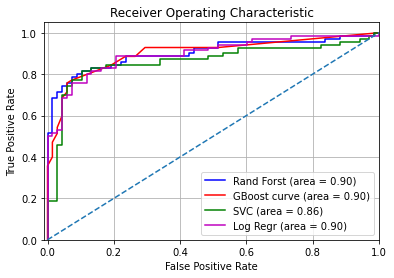

In [23]:
# Plotting ROC curve
plt.plot(fpr_random_forest_clf, tpr_random_forest_clf,
         label='Rand Forst (area = {:.2f})'.format(random_forest_roc_auc), c = 'b')
plt.plot(fpr_Gboost_clf, tpr_Gboost_clf,
         label='GBoost curve (area = {:.2f})'.format(Gboost_roc_auc), c = 'r')
plt.plot(fpr_svm_clf, tpr_svm_clf, label='SVC (area = {:.2f})'.format(svm_roc_auc), c = 'g')
plt.plot(fpr_logr_clf, tpr_logr_clf, label='Log Regr (area = {:.2f})'.format(logr_roc_auc),
         c = 'm')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

We can see both from the plots and the AUC values that the performance of each classifier is actually quite similar overall.

***
## Feature importance
We will now investigate feature importance for the best performing model (Random Forest). This is somewhat non trivial as we have used one hot encoding.

First we will work out the importances for the encoded features and create a new dataframe where one hot encoded variables' features are summed up to give the original importance.

In [24]:
importances_array = best_random_forest_clf.feature_importances_
original_features_num = X_train_num.columns
original_features_cat = X_train_cat.columns
nuniques = X_train_cat.nunique()

importances = pd.Series(dtype = 'object')

# Fill out numericals
for i in range(len(X_train_num_scaled[0])):
    importances[original_features_num[i]] = importances_array[i]

num_numerical_cols = len(X_train_num_scaled[0])

# Fill out categoricals
counter = 0
for i in range(len(X_train_cat.iloc[0])):
    onehots = nuniques[original_features_cat[i]].item() - 1 # subtract 1 due to drop first in encoding
    
    sum_per_col = 0
    for _ in range(onehots):
        sum_per_col += importances_array[num_numerical_cols + counter]
        counter += 1
    
    importances[original_features_cat[i]] = sum_per_col

In [25]:
display(importances)

A2     0.032953
A3     0.035901
A8     0.098012
A11    0.099425
A14    0.018732
A15    0.143075
A1     0.000000
A4     0.019623
A5     0.012536
A6     0.031682
A7     0.068209
A9     0.264885
A10    0.172494
A12    0.000000
A13    0.002475
dtype: float64

From this series, we can observe that A9, A10 and A15 are the most relevant features for predicting credit approval, with A9 being the most important, followed by A10 and A15.

***
## Conclusion
In this notebook we took a close look at using four different machine learning classifiers to predict credit approval ratings, training them using a hyperparameter cross validation grid search and then comparing their performances. Finally, we used our best performing model to make inferences from the data, by seeing which features were most relevant to our model and which were not useful in making predictions.